In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner


## Agent Based Model Lab
First let's go through the Forest Fire model example. 

We designate the agent: the tree, and the environment: the grid. The tree can be in one of three stages: unburned, on fire, or already burned. 

In [11]:
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

Here we use a tuple of the tree's coordinates as it unique identifier. We also create an if statement that tells a tree that is on Fire to "spread" the fires to neighboring trees that are Fine and subsequently Burn Out. 

Now we create the environment that these trees will be in. We determine the extent of the grid and the density of trees in the grid. We make it so the model runs until all there are not trees left on fire. Then a data collector is set up that initiates the model and sets the trees on fire and also counts the trees that are in each of the three stages. 

In [12]:
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

Now we create our model using the parameters we set. First we determine the dimensions of the grid: height, width, density.

In [14]:
fire = ForestFire(100, 100, 0.6)

Run the model until there are no more trees that are still on fire. 

In [15]:
fire.run_model()

However, we want to visualize this model so we use the data collected from the data collector and turn it into a pandas dataframe and plot it. 

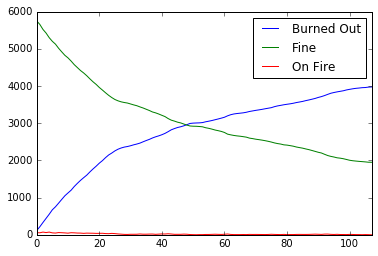

In [17]:
results = fire.dc.get_model_vars_dataframe()
results.plot()

Here we can see that the grid was not completely burned out, some fine trees still remained at the end. If we change the parameters, however, we can get a result of the no fine trees remaining at the end. 

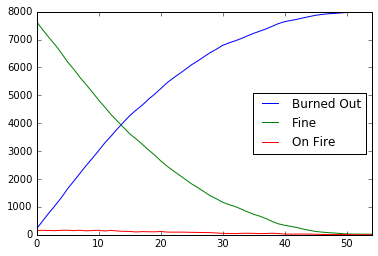

In [18]:
fire = ForestFire(100, 100, 0.8)
fire.run_model()
results = fire.dc.get_model_vars_dataframe()
results.plot()

## Batch Runs
In order to really understand how the outcome varies with density we should do a batch run. A batch run uses the parameters and the values they can take and runs the model at each combination of these values. Adding a reporter to the batch run will store the results of each run. In this batch run the height and width are constant but the density varies from .01 to 1. 

In [19]:
param_set = dict(height=50, # Height and width are constant
                 width=50,
                 # Vary density from 0.01 to 1, in 0.01 increments:
                 density=np.linspace(0,1,101)[1:])

Here we create the model reporter. 

In [20]:
# At the end of each model run, calculate the fraction of trees which are Burned Out
model_reporter = {"BurnedOut": lambda m: (ForestFire.count_type(m, "Burned Out") / 
                                          m.schedule.get_agent_count()) }

In [21]:
# Create the batch runner
param_run = BatchRunner(ForestFire, param_set, model_reporters=model_reporter)

We have created the batch runner and will tell it to run the model at all combinations of the parameters.

In [22]:
param_run.run_all()

100%|██████████| 100/100 [00:06<00:00,  7.43it/s]


We use the same method as before with the data collector and extract the data from the reporter into a dataframe that we visualize. 

In [23]:
df = param_run.get_model_vars_dataframe()
df.head()

,BurnedOut,Run,density,height,width
0,0.156143,45,0.46,50,50
1,0.953353,68,0.69,50,50
2,0.976860,71,0.72,50,50
3,0.023599,12,0.13,50,50
4,0.102059,43,0.44,50,50


Each run has it unique indentifier under Run and it shows the percent Burned Out for each change in density. Now let's plot this. 

(0, 1)

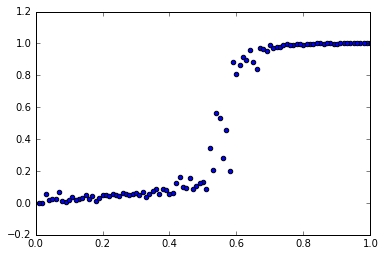

In [24]:
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)

If we want to get a more statistically accurate representation of the effect of the change in density we can tell the batch runner to run the model multiple times at each parameter combination. We do this with iterations. 

100%|██████████| 500/500 [00:33<00:00,  7.08it/s]


(0, 1)

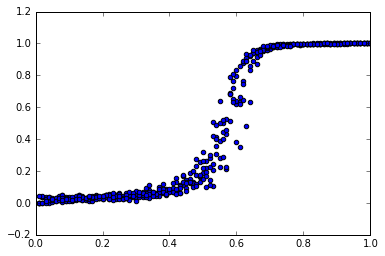

In [25]:
param_run = BatchRunner(ForestFire, param_set, iterations=5, model_reporters=model_reporter)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)